In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
import os  

def is_even(num) -> bool: 
    return num % 2 == 0 

def is_odd(num) -> bool: 
    return num % 2 != 0 

In [4]:

def i_file_read(path: str): 
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16) 

    I = data[0::2]
    Q = data[1::2]

    return I, Q
I, Q = i_file_read('./txdata.pcm') 

print(I)
print(Q)

[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


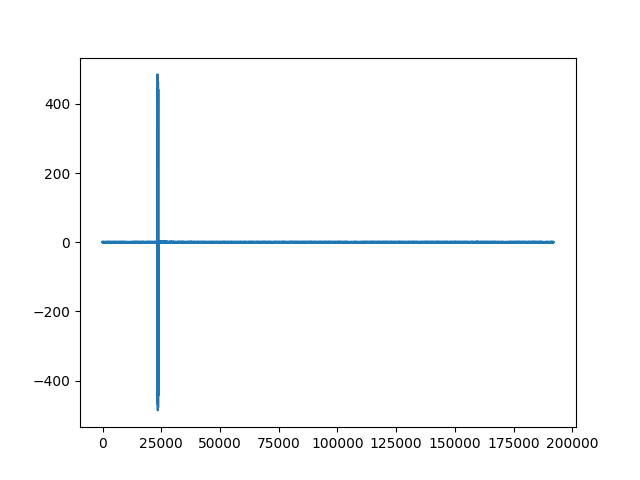

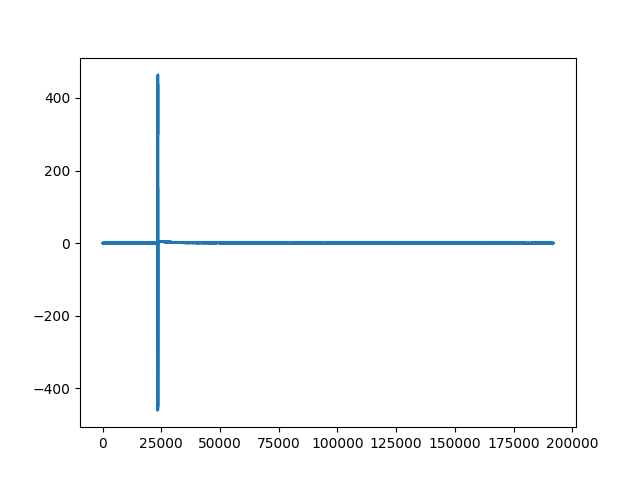

In [5]:
def i_q_visio(): 
    # fig, ax = plt.subplots()

    # #ax.plot(I, Q, label='Scatter plot', color='red')
    # ax.plot(Q)

    # ax.set_xlabel('X-axis label')
    # ax.set_ylabel('Y-axis label')
    # ax.set_title('Simple Scatter Plot')
    # ax.legend()

    fig1, ax = plt.subplots()

    #ax.plot(I, Q, label='Scatter plot', color='red')
    ax.plot(I)

    # ax.set_xlabel('X-axis label')
    # ax.set_ylabel('Y-axis label')
    # ax.set_title('Simple Scatter Plot')
    # ax.legend()

    fig2, ax2 = plt.subplots()

    #ax.plot(I, Q, label='Scatter plot', color='red')
    ax2.plot(Q)

    # ax2.set_xlabel('X-axis label')
    # ax2.set_ylabel('Y-axis label')
    # ax2.set_title('Simple Scatter Plot')
    # ax2.legend()
i_q_visio()



In [6]:
# filt = 

This is a display math example:
$$
\int_0^\infty e^{-x^2} dx = \frac{\sqrt{\pi}}{2}
$$

$$
T_{symb}
$$


In [7]:
def match_filter(): 
    T_symb = 0.5
    
    

In [8]:
def qpsk_modulate(v_bits): 
    S = np.array(); 
    for i in range(len(v_bits)):
        bit = v_bits[i] 

        if (bit == 0): 
            bit = -1
        else: 
            bit = 1 

        if (is_even(i)): # I 
            S.append(bit * np.cos() )
        #if (is_odd(i)):  # Q 
